### Applying TF
This example notebook solves the same problem from the [Stanford CNN site](http://cs231n.github.io/neural-networks-case-study/) but uses Tensor Flow instead of building the backprop process from scratch.

In [53]:
import numpy as np
import scipy as sp
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline

In [103]:
# Build the same data set...
N = 125
Ntest = 40
D = 2
K = 4
X = np.zeros((N*K, D)) # row is a single vector (x1, x2)
y = np.zeros(N*K, dtype='uint8')
y_onehot = np.zeros((N*K, K))
Xtest = np.zeros((Ntest*K, D))
ytest = np.zeros(Ntest*K, dtype='uint8')
y_onehot_test = np.zeros((Ntest*K, K))

for i in xrange(K):
    xidx = range(N*i,N*(i+1))
    xt_idx = range(Ntest*i,Ntest*(i+1))
    r = np.linspace(0.0,1,N)
    theta = np.linspace(i*4, (i+1)*4, N) + np.random.randn(N)*0.15
    X[xidx] = np.c_[r*np.sin(theta), r*np.cos(theta)]
    y[xidx] = i
    class_as_onehot = np.zeros(K)
    class_as_onehot[i] = 1
    y_onehot[xidx] = class_as_onehot
    r_test = np.linspace(0.0,1,Ntest)
    theta_test = np.linspace(i*4, (i+1)*4, Ntest) + np.random.randn(Ntest)*0.25
    Xtest[xt_idx] = np.c_[r_test*np.sin(theta_test), r_test*np.cos(theta_test)]
    ytest[xt_idx] = i
    class_as_onehot_test = np.zeros(K)
    class_as_onehot_test[i] = 1
    y_onehot_test[xt_idx] = class_as_onehot_test

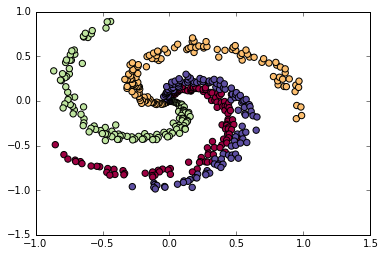

In [55]:
plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.Spectral)

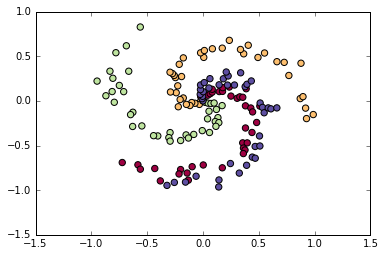

In [56]:
plt.scatter(Xtest[:, 0], Xtest[:, 1], c=ytest, s=40, cmap=plt.cm.Spectral)

In [63]:
# TF placeholder for the input and target data (y_targ)
x = tf.placeholder(tf.float32, [None, 2])
y_targ = tf.placeholder(tf.float32, [None, K])

In [64]:
# Layer 1 - ReLU activation layer
num_neurons = 20
W = tf.Variable(tf.zeros([2,num_neurons]))
b = tf.Variable(tf.zeros([num_neurons]))
layer1 = tf.nn.relu(tf.matmul(x, W) + b)

In [65]:
# Layer 2 - Softmax to generate class probabilities
W2 = tf.Variable(tf.zeros([num_neurons,K]))
b2 = tf.Variable(tf.zeros([K]))
class_probs = tf.nn.softmax(tf.matmul(layer1, W2) + b2)